<p align="right">
04-24-2025  <br>
BI and Analytics Spring 2025  <br>
Joanna Farris
</p>


--------

# Custom BI Project – Marketing Campaign Response

This notebook presents a business intelligence analysis of customer response to a marketing campaign.  
The goal is to identify which customer characteristics are most strongly associated with a positive response, using real-world data and BI techniques.

The analysis follows a structured workflow that includes loading and transforming data, applying OLAP operations, generating visual insights, and reflecting on challenges and ethical considerations.


## Section 1: The Business Goal

**Business Question:**  

Which customer characteristics are most strongly associated with a positive response to a marketing campaign?


## Section 2: Data Source

**Dataset:**  

Marketing Customer Value Analysis (CSV from Kaggle)

**Details:**  
- Demographics: Age, education, marital status  
- Behavior: Web visits, purchases, campaign responses  
- Goal: Identify characteristics of high-response customers


## Section 3: Tools Used

- Python  
- PySpark  
- Seaborn + Matplotlib  
- JupyterLab in VS Code


## Section 4: Workflow & Logic

**Steps:**  
- Load data using PySpark  
- Clean columns and convert date fields  
- Engineer new fields: Customer_Tenure_Days, Total_Spend, Income_Bin  
- Slice and dice by Education, Income, Marital_Status, and Response  
- Aggregate using Spark groupBy and convert to Pandas for plotting  
- Visualize using bar plots, heatmaps, donut, and box plots


In [213]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, avg, count, round, when, col
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Start Spark session
spark = SparkSession.builder.appName("MarketingNotebook").getOrCreate()

# Define path
DATA_PATH = pathlib.Path("../data/raw/marketing_data.csv")

# Load dataset
df = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .option("sep", ",")
    .csv(str(DATA_PATH))
)

df.show(5)

+----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+
|  ID|Year_Birth| Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|
+----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+----------

In [214]:
spark.sparkContext.setLogLevel("WARN")

In [215]:
# Convert string to date
df = df.withColumn("Dt_Customer", to_date("Dt_Customer", "dd-MM-yyyy"))

# Optional preview
df.select("ID", "Dt_Customer").show(5)


+----+-----------+
|  ID|Dt_Customer|
+----+-----------+
|5524| 2012-09-04|
|2174| 2014-03-08|
|4141| 2013-08-21|
|6182| 2014-02-10|
|5324| 2014-01-19|
+----+-----------+
only showing top 5 rows



In [216]:
# Group and aggregate
grouped_df = df.groupBy("Education", "Response").agg(
    count("*").alias("Customer_Count"),
    round(avg("Income"), 0).alias("Avg_Income")
)

# Preview results
grouped_df.show()


+----------+--------+--------------+----------+
| Education|Response|Customer_Count|Avg_Income|
+----------+--------+--------------+----------+
|     Basic|       1|             2|   18456.0|
|  2n Cycle|       0|           181|   46618.0|
|    Master|       0|           313|   51813.0|
|Graduation|       1|           152|   60920.0|
|     Basic|       0|            52|   20377.0|
|Graduation|       0|           975|   51427.0|
|  2n Cycle|       1|            22|   55849.0|
|       PhD|       1|           101|   61581.0|
|       PhD|       0|           385|   54701.0|
|    Master|       1|            57|   59012.0|
+----------+--------+--------------+----------+



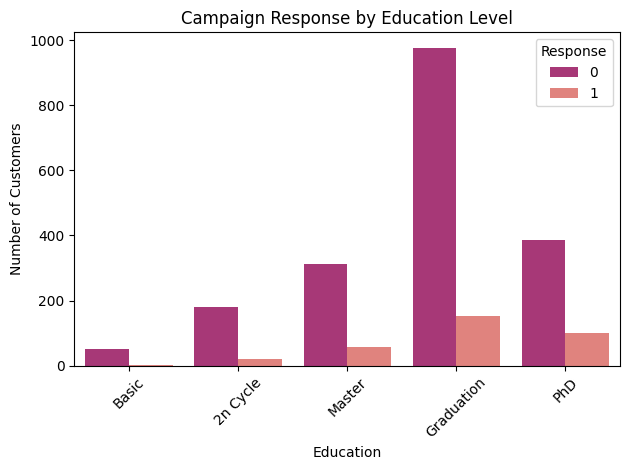

In [217]:
# Convert Spark DataFrame to Pandas
grouped_pd = grouped_df.toPandas()

# Bar plot: campaign response by education level
colors = ["#B9257A", "#F0746E"]  # bold magenta and warm coral-red

sns.barplot(data=grouped_pd,
    x="Education",
    y="Customer_Count",
    hue="Response",
    palette=colors
)
plt.title("Campaign Response by Education Level")
plt.ylabel("Number of Customers")
plt.xlabel("Education")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Education vs Response:**  

Higher education levels (especially PhD) had slightly better response rates. Still low overall.


In [218]:
# Group and aggregate by Marital_Status and Response
marital_group = df.groupBy("Marital_Status", "Response").agg(
    count("*").alias("Customer_Count"),
    round(avg("Income"), 0).alias("Avg_Income")
)

marital_group.show()


+--------------+--------+--------------+----------+
|Marital_Status|Response|Customer_Count|Avg_Income|
+--------------+--------+--------------+----------+
|         Widow|       0|            58|   54791.0|
|          YOLO|       1|             1|   48432.0|
|        Single|       1|           106|   60539.0|
|       Married|       1|            98|   60234.0|
|       Married|       0|           766|   50626.0|
|         Alone|       0|             2|   47754.0|
|        Single|       0|           374|   48224.0|
|          YOLO|       0|             1|   48432.0|
|         Widow|       1|            19|   61928.0|
|         Alone|       1|             1|   35860.0|
|      Together|       1|            60|   58180.0|
|      Divorced|       1|            48|   61683.0|
|      Divorced|       0|           184|   50526.0|
|        Absurd|       1|             1|   79244.0|
|      Together|       0|           520|   52668.0|
|        Absurd|       0|             1|   65487.0|
+-----------

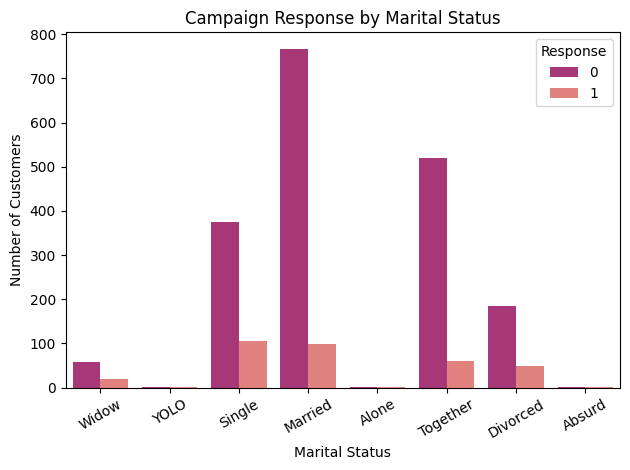

In [219]:
# Convert to Pandas
marital_pd = marital_group.toPandas()

# Plot
colors = ["#B9257A", "#F0746E"] # bold magenta and warm coral-red

sns.barplot(
    data=marital_pd,
    x="Marital_Status",
    y="Customer_Count",
    hue="Response",
    palette=colors
)
plt.title("Campaign Response by Marital Status")
plt.ylabel("Number of Customers")
plt.xlabel("Marital Status")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


**Marital Status vs Response:**  

Singles responded more than married or together customers. Small but clear difference.


In [220]:
# Create income bins
df = df.withColumn(
    "Income_Bin",
    when(col("Income") < 30000, "<30k")
    .when((col("Income") >= 30000) & (col("Income") < 60000), "30k–60k")
    .when((col("Income") >= 60000) & (col("Income") < 90000), "60k–90k")
    .otherwise("90k+")
)


In [221]:
income_group = df.groupBy("Income_Bin", "Response").agg(
    count("*").alias("Customer_Count"),
    round(avg("Income"), 0).alias("Avg_Income")
)

income_group.show()

+----------+--------+--------------+----------+
|Income_Bin|Response|Customer_Count|Avg_Income|
+----------+--------+--------------+----------+
|   30k–60k|       1|           113|   43782.0|
|      <30k|       0|           331|   21495.0|
|      90k+|       0|            51|  130300.0|
|   60k–90k|       1|           155|   76214.0|
|   60k–90k|       0|           633|   71450.0|
|   30k–60k|       0|           891|   44601.0|
|      90k+|       1|            27|   94516.0|
|      <30k|       1|            39|   21328.0|
+----------+--------+--------------+----------+



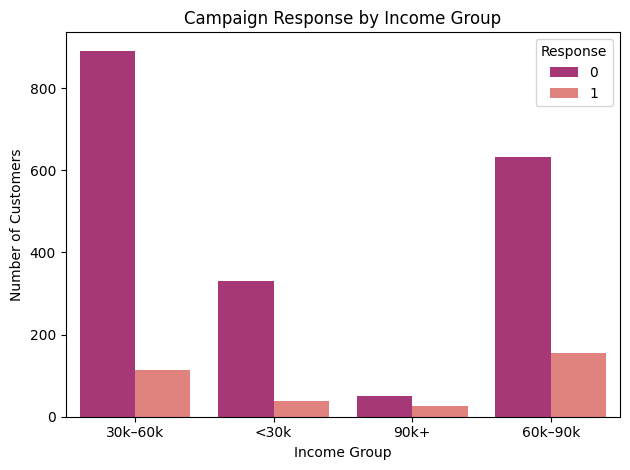

In [222]:
# Convert to Pandas
income_pd = income_group.toPandas()

# Plot
colors = ["#B9257A", "#F0746E"]  # bold magenta and warm coral-red

sns.barplot(
    data=income_pd,
    x="Income_Bin",
    y="Customer_Count",
    hue="Response",
    palette=colors
)
plt.title("Campaign Response by Income Group")
plt.ylabel("Number of Customers")
plt.xlabel("Income Group")
plt.tight_layout()
plt.show()


**Income vs Response:**  

Higher income groups had higher response rates. The 90k+ group stood out.


In [223]:
# Group by Income_Bin and Response
stacked_df = df.groupBy("Income_Bin", "Response").count().toPandas()

# Convert Response to string for plotting
stacked_df["Response"] = stacked_df["Response"].astype(str)

# Pivot to wide format for stacking
pivot_df = stacked_df.pivot(index="Income_Bin", columns="Response", values="count").fillna(0)
pivot_df = pivot_df.sort_index()


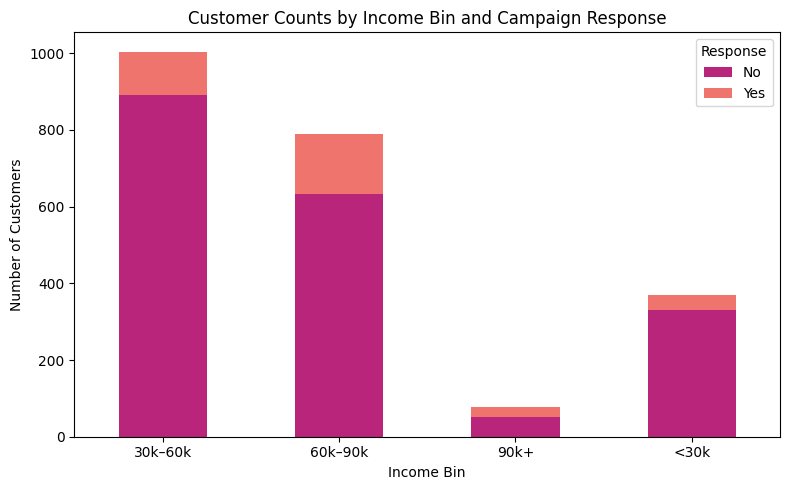

In [224]:
# Choose more than two colors
colors = ["#B9257A", "#F0746E"]  # bold magenta and warm coral-red

# Plot
pivot_df.plot(
    kind="bar",
    stacked=True,
    color=colors,
    figsize=(8, 5)
)
plt.title("Customer Counts by Income Bin and Campaign Response")
plt.xlabel("Income Bin")
plt.ylabel("Number of Customers")
plt.legend(title="Response", labels=["No", "Yes"])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


**Income Bin + Response (Stacked):**  

Most customers are in the 30k–60k and 60k–90k ranges. But the few in the 90k+ group responded more.


In [225]:
# Group by Education + Income_Bin + Response
heatmap_df = df.groupBy("Education", "Income_Bin", "Response").count().toPandas()

# Convert Response to string
heatmap_df["Response"] = heatmap_df["Response"].astype(str)


In [226]:
# Pivot to get total counts per group
total_counts = heatmap_df.groupby(["Education", "Income_Bin"])["count"].sum().reset_index()
response_counts = heatmap_df[heatmap_df["Response"] == "1"]

# Merge totals and calculate response rate
merged = response_counts.merge(total_counts, on=["Education", "Income_Bin"], suffixes=("_response", "_total"))
merged["Response_Rate"] = merged["count_response"] / merged["count_total"]


In [227]:
# Pivot into 2D grid for heatmap
heatmap_data = merged.pivot(index="Education", columns="Income_Bin", values="Response_Rate")


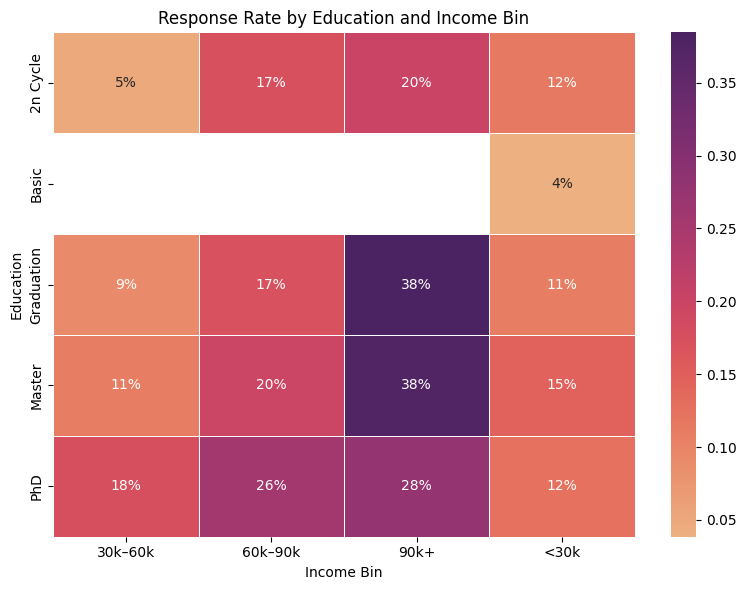

In [228]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".0%",
    cmap="flare",  # warm-to-purple palette
    linewidths=0.5
)
plt.title("Response Rate by Education and Income Bin")
plt.xlabel("Income Bin")
plt.ylabel("Education")
plt.tight_layout()
plt.show()


**Response Rate by Education and Income:**  

Best response rates came from high-income, well-educated customers. Some overlap with single status.


In [229]:
df = df.withColumn(
    "Total_Spend",
    col("MntWines") +
    col("MntFruits") +
    col("MntMeatProducts") +
    col("MntFishProducts") +
    col("MntSweetProducts") +
    col("MntGoldProds")
)



In [230]:
spend_group = df.groupBy("Response").agg(
    round(avg("Total_Spend"), 0).alias("Avg_Total_Spend"),
    count("*").alias("Customer_Count")
)

spend_group.show()


+--------+---------------+--------------+
|Response|Avg_Total_Spend|Customer_Count|
+--------+---------------+--------------+
|       1|          987.0|           334|
|       0|          539.0|          1906|
+--------+---------------+--------------+



/var/folders/s7/d6_jmkk96kn7w3t6vjr0_h640000gn/T/ipykernel_78230/1418375385.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


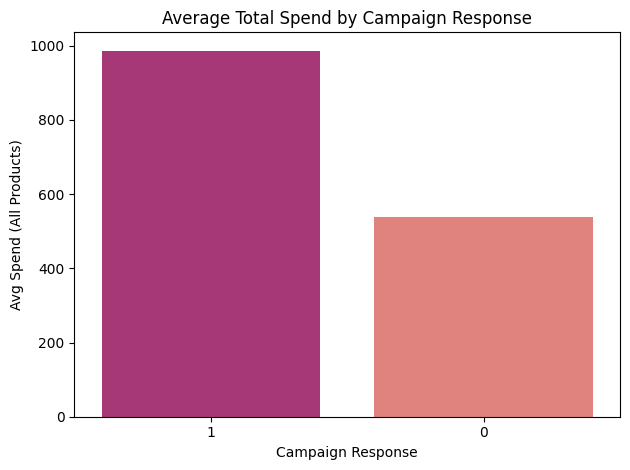

In [231]:
# Convert to Pandas
spend_pd = spend_group.toPandas()
spend_pd["Response"] = spend_pd["Response"].astype(str)  # ensures hue works

# Plot
sns.barplot(
    data=spend_pd,
    x="Response",
    y="Avg_Total_Spend",
    palette=colors
)
plt.title("Average Total Spend by Campaign Response")
plt.ylabel("Avg Spend (All Products)")
plt.xlabel("Campaign Response")
plt.tight_layout()
plt.show()


**Avg Spend by Response:**  

Responders spend way more — almost double the average of non-responders.


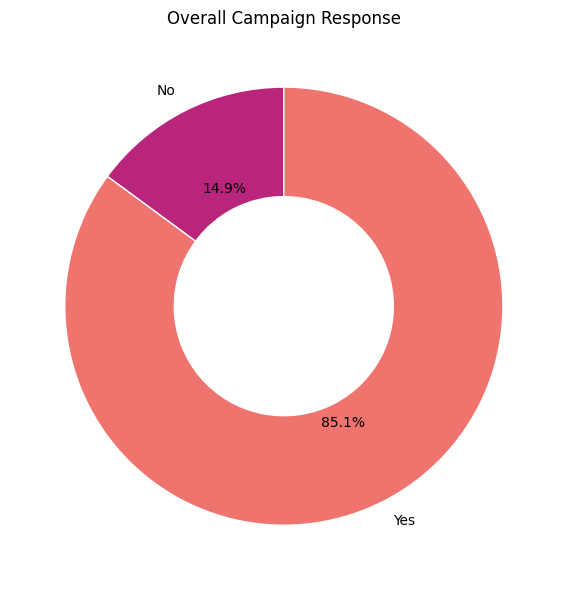

In [232]:
# Get total responders vs non-responders
response_counts = df.groupBy("Response").count().toPandas()
response_counts["Response"] = response_counts["Response"].astype(str)

# Set labels and colors
labels = ["No", "Yes"]
sizes = response_counts["count"]
colors = ["#B9257A", "#F0746E"]  

# Plot donut chart
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    startangle=90,
    wedgeprops={"width": 0.5, "edgecolor": "white"},
    autopct="%1.1f%%"
)
plt.title("Overall Campaign Response")
plt.tight_layout()
plt.show()


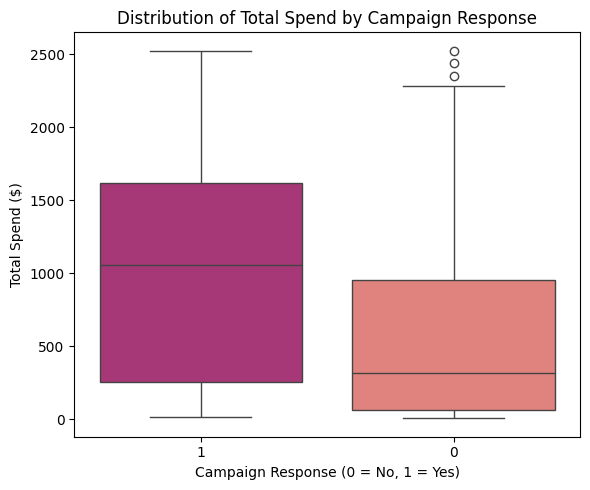

In [233]:
plt.figure(figsize=(6, 5))
sns.boxplot(
    data=box_df,
    x="Response",
    y="Total_Spend",
    hue="Response",                # ← assign the hue explicitly
    palette=colors,
    dodge=False,                   # ← avoids duplicating the boxes
    legend=False                   # ← hides the duplicate legend
)
plt.title("Distribution of Total Spend by Campaign Response")
plt.xlabel("Campaign Response (0 = No, 1 = Yes)")
plt.ylabel("Total Spend ($)")
plt.tight_layout()
plt.show()


**Overall Campaign Response:**  

Only ~15% responded to the campaign. Majority didn’t.


## Section 5: Results (narrative + visualizations)

*See visualizations and insights throughout the notebook.*

- Customers with higher income and higher education levels were more likely to respond.
- Single customers responded more often than married or together.
- Responders had a much higher average total spend.
- Most customers didn’t respond to the campaign (~15% did).
- Spending among responders varied more — some spent a lot.


## Section 6: Suggested Business Action

Focus marketing efforts on high-income, single, and highly educated customers.  
They’re more likely to respond and also spend more.  
Test targeted campaigns for this group to improve conversion and ROI.


## Section 7: Challenges

Getting charts to show what I wanted took some trial and error.  
Figuring out how to clean and group the data in Spark was also slow at first.


In [234]:
spark.stop()
